### ***Name***: *Elias CHERIF*
### ***username***: *gems-ec2823*
### ***CID***: *02522867*




In [1]:
!pip install pycm livelossplot
%pylab inline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.8/599.8 kB 11.6 MB/s eta 0:00:00
Populating the interactive namespace from numpy and matplotlib


## Data preparation

In [2]:
from google.colab import drive
drive.mount('/content/drive')  #access the images I have stored in my drive

Mounted at /content/drive


In [147]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import torchvision.datasets
import torchvision.transforms as transforms

In [148]:
def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  ##uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    device = 'cuda'
else:
    print("No GPU available!")

No GPU available!


In [149]:
seed = 42
set_seed(seed)

True

In [150]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image

directories = ["/content/drive/My Drive/real_hands",
               "/content/drive/My Drive/VAE_hands",
               "/content/drive/My Drive/GAN_hands"]

In [151]:
import torchvision.transforms.functional as TF

class CustomDataset(Dataset):
    def __init__(self, directories, transform=None):
        self.transform = transform
        self.samples = []

        for label, directory in enumerate(directories):
            for filename in os.listdir(directory):
                path = os.path.join(directory, filename)
                self.samples.append((path, label))
                self.samples.append((path, label, 'rotate'))
                self.samples.append((path, label, 'noise'))
                self.samples.append((path, label, 'brightness'))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label, *transformation = self.samples[idx]
        image = Image.open(path).convert('L')

        if transformation:
            if transformation[0] == 'rotate':
                image = TF.rotate(image, 10)
            elif transformation[0] == 'noise':
                image = self.add_noise(image)
            elif transformation[0] == 'brightness':
                image = TF.adjust_brightness(image, brightness_factor=1.2)

        if self.transform:
            image = self.transform(image)

        return image, label

    @staticmethod
    def add_noise(image):
        image_tensor = TF.to_tensor(image)
        noise = torch.randn(image_tensor.size()) * 0.05
        noisy_image = image_tensor + noise
        return TF.to_pil_image(torch.clamp(noisy_image, 0, 1))

For each image in these folders, several entries are created in a list:
An entry for the original image.
An entry for a version of the image that will be rotated (by 10 degrees).
An entry for a version of the image with noise added: Random noise is added to the image using a Gaussian noise tensor.
An entry for a version of the image with brightness adjustment: The brightness of the image is increased (brightness factor of 1.2 here).

The CustomDataset class can therefore be used to create an extended dataset with image variations, to increase robustness given that the basic dataset is not very extensive.

In [152]:
transformations = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

1. transforms.Resize((32, 32)) :
- This transformation resizes all images to a size of 32x32 pixels.
2. transforms.ToTensor():
- This transformation converts the images into PyTorch tensors.
3. transforms.Normalize([0.5], [0.5]):
- The range of pixel values will be transformed to lie approximately between -1.0 and 1.0. Normalization helps to stabilise and accelerate convergence during neural network training.

In [153]:
dataset = CustomDataset(directories, transform=transformations)
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
validation_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

train_size, val_size, test_size are calculated to determine the size of the training, validation and test sets, respectively. Here, 60% of the data is allocated to training, 20% to validation and the remaining 20% to test.

In [154]:
len(dataset)

5776

## Network design and implementation

In [155]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = x.view(-1, 64 * 8 * 8)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)

- I've tried a number of more complex designs, but for hand detection, I've found that a simple model gives more satisfaction.

- SimpleCNN is a convolutional neural network designed to process images. It comprises two convolutional layers followed by two fully connected layers. Each convolutional layer, which uses filters to extract spatial features from the image, is followed by a ReLU activation function and a max pooling operation to reduce the spatial dimensions while retaining the most important features. After the convolutional layers, the data is flattened and passed through two fully connected layers, the last of which produces a three-class output.

- nn.BatchNorm2d is added immediately after each convolutional layer. Batch normalisation speeds up training and improves performance by normalising the output of each convolutional layer. This reduces the problem of vanishing gradients and can also act as a regularisation.

- nn.Dropout is added just before the last fully connected layer. Dropout randomly disables a percentage of neurons (in this example, 20%) during training, which helps prevent overfitting by forcing the network not to rely too heavily on a small number of neurons.

## Training

In [157]:
def train(model, optimizer, criterion, data_loader):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    train_loss = running_loss / len(data_loader)
    train_accuracy = 100 * correct / total
    return train_loss, train_accuracy

def validate(model, criterion, data_loader):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss = running_loss / len(data_loader)
    val_accuracy = 100 * correct / total
    return val_loss, val_accuracy




The train function trains a neural network model on a given data set, updates the model weights using the optimizer and calculates the average loss and accuracy for the training set.
The validate function evaluates the performance of the model on a validation set, calculating the average loss and accuracy without modifying the model weights.

In [158]:
seed = 42
lr = 0.001 # gives the best result (with a manual grid_search)
batch_size = 32 # gives the best result (with a manual grid_search)
test_batch_size = 32



In [159]:
criterion = nn.CrossEntropyLoss()

## Network training


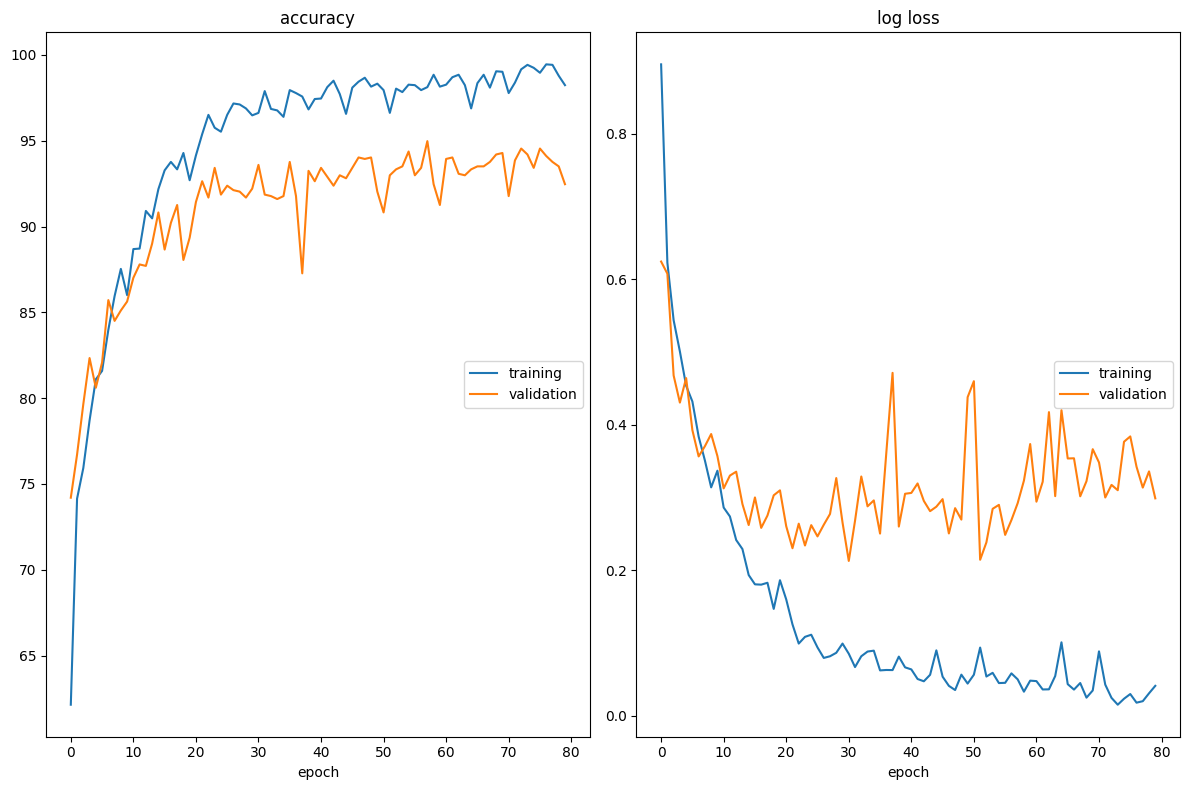

accuracy
	training         	 (min:   62.136, max:   99.452, cur:   98.240)
	validation       	 (min:   74.199, max:   94.978, cur:   92.468)
log loss
	training         	 (min:    0.015, max:    0.895, cur:    0.041)
	validation       	 (min:    0.213, max:    0.624, cur:    0.299)


In [160]:
def train_model():
  set_seed(seed)
  optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
  criterion = nn.CrossEntropyLoss()

  liveloss = PlotLosses()
  for epoch in range(80):
      logs = {}
      train_loss, train_accuracy = train(model, optimizer, criterion, train_loader)

      logs['' + 'log loss'] = train_loss
      logs['' + 'accuracy'] = train_accuracy

      validation_loss, validation_accuracy = validate(model, criterion, validation_loader)
      logs['val_' + 'log loss'] = validation_loss
      logs['val_' + 'accuracy'] = validation_accuracy

      liveloss.update(logs)
      liveloss.draw()

  return model

model = train_model().to(device)

The training accuracy rises rapidly and then stabilises at around 99%, indicating that the model is learning well on the training set.
Validation accuracy increases and eventually stabilises around a value while fluctuating.
The validation loss, after an initial drop, seems to start increasing slowly and fluctuating, which is a sign that the model is starting to overfit. I don't rule out the idea that by increasing the number of epochs, validation loss continues to increase. If that's the case, then we're in a configuration where I've used early stopping.
To avoid this, we need to review the learning rate, batch size and dropout rates to find a better balance between learning and generalisation.

In [161]:
from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(all_labels, all_preds)


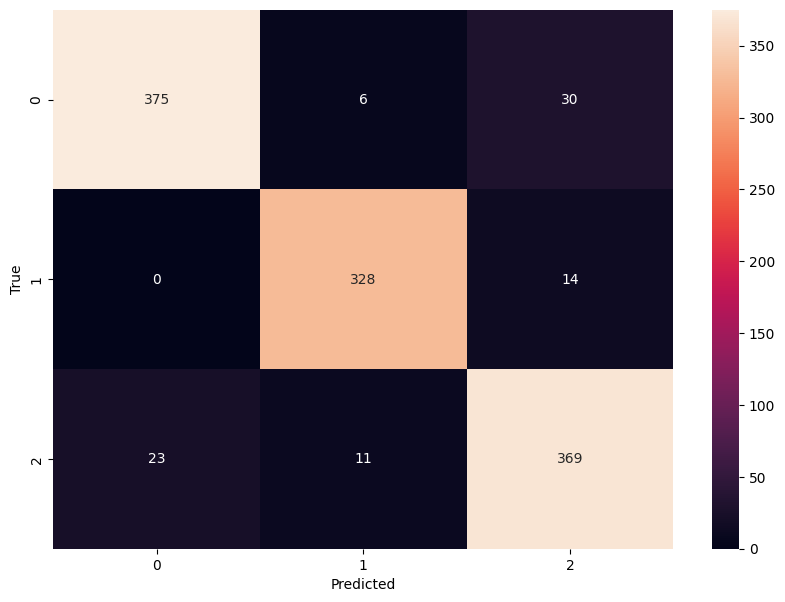

In [162]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


You can view our confusion matrix on our test_set and you can see that the results are quite good (about 92% accuracy).

## CSV file




In [167]:
import csv

class InferenceDataset(Dataset):
    def __init__(self, directory, transform=None):
        self.transform = transform
        self.samples = [(os.path.join(directory, fname), fname) for fname in os.listdir(directory)]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, fname = self.samples[idx]
        image = Image.open(path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, fname


transformations = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

inference_dataset = InferenceDataset("/content/drive/My Drive/test_hands", transform=transformations)
inference_loader = DataLoader(inference_dataset, batch_size=32, shuffle=False)

model.eval()
predictions = []
with torch.no_grad():
    for images, fnames in inference_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions.extend(zip(fnames, predicted.cpu().numpy()))

we prepare our test data first before making the prediction

In [168]:
with open('gems-ec2823_classified_hands.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    for fname, pred in predictions:
        csvwriter.writerow([fname, pred])
